In [1]:
import sys
print(sys.version)

3.6.9 |Anaconda custom (64-bit)| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on Mar 3 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *




In [6]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)

1.17.4
0.15.0
1.3.1


## unit test 

In [16]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28
npix_value:1280
Science image shape is: (50, 50)
Top left pixel value of the science image is: 1.0
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (50, 50)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [   24.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hsc

In [17]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

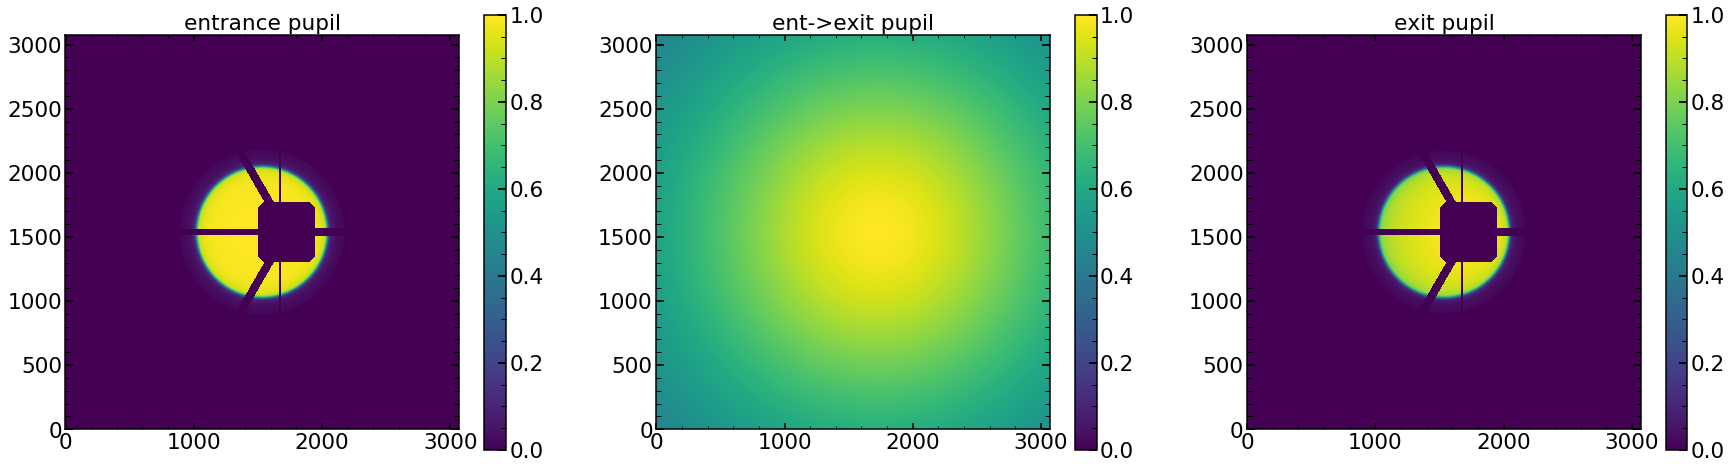

In [18]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

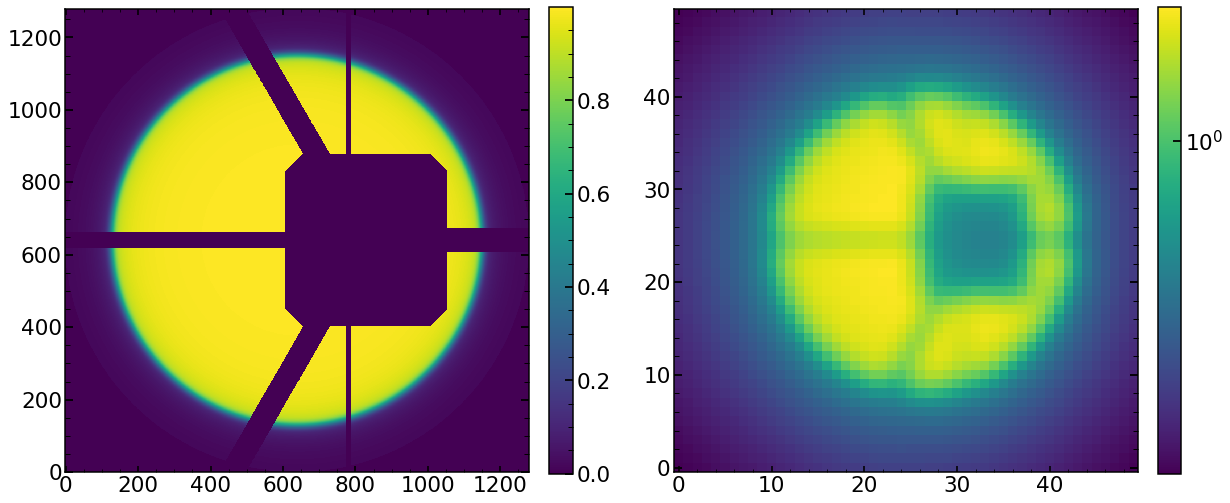

In [19]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([1,10**-2,10**-3,10**-4,10**-5,10,10**2,10**3,10**4,10**5])

# Custom size of ilum_radiometric 

## simulations

In [25]:
sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1,simulation_00=1)   
res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28
npix_value:512
Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hscF

In [ ]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

In [ ]:
plt.imshow(optPsf_cut_fiber_convolved_downsampled)

In [32]:
# compare results from 50x50 image and 20x20 image - both on real data and when sim00=1

28.95

In [56]:
sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,npix=1536,verbosity=1,sim)   
res=model(allparameters_proposal,return_Image=True)
optPsf_cut_fiber_convolved_downsampled_1536=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1)   
res=model(allparameters_proposal,return_Image=True)
optPsf_cut_fiber_convolved_downsampled_20=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hscFrac', 'strutFrac', 'dxFocal', 'dyFocal', 'sl

Time for cutting out the square is 0.14879894256591797
Finished with getPupil
Finished with _get_Pupil
 
Time for single pupil calculation is 0.4267399311065674
Supplied pupil size is (pupil.size) [m]: 0.1395327
One pixel has size of (pupil.scale) [m]: 0.00013626240234375
Supplied pupil has so many pixels (pupil_plane_im): (1024, 1024)
Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 0.0, 0.09, 0.02, -0.1, 0.0, 0.1, 0.02, 0.2]
aberrations 0 [0.0, 0.0, 0.0, 0.0, 0, 0.09, 0.02, -0.1, 0.0, 0.1, 0.02, 0]
aberrations extra: None
self.wavelength: 794
lower_limit_of_ilum: 512
higher_limit_of_ilum: 1536
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (2048, 2048)
size_of_ilum_in_units_of_radius: 2.0
Time for FFT is 0.1808640956878662
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (2048, 2048)
oversampling_original: 35.374287997579025
size_of_central_cut: 990
optPsf_cut.shape(991, 

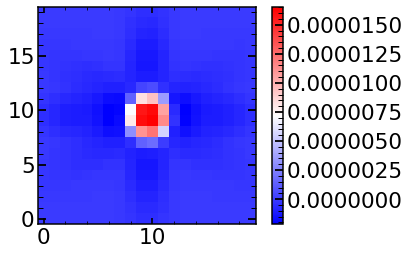

In [64]:
optPsf_cut_fiber_convolved_downsampled_1536=optPsf_cut_fiber_convolved_downsampled_1536*np.sum(1)/np.sum(optPsf_cut_fiber_convolved_downsampled_1536)
optPsf_cut_fiber_convolved_downsampled_20=optPsf_cut_fiber_convolved_downsampled_20/np.sum(optPsf_cut_fiber_convolved_downsampled_20)

plt.imshow(optPsf_cut_fiber_convolved_downsampled_20-optPsf_cut_fiber_convolved_downsampled_1536,cmap='bwr')
plt.colorbar()

## checking with the real data 

### ``old'' version

In [26]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [27]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [30]:

date='Feb1420'
obs=21346+54
obs_int=int(obs)
single_number='57'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]
double_sources=0
double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
double_sources_positions_ratios

0d


array([0, 0], dtype=object)

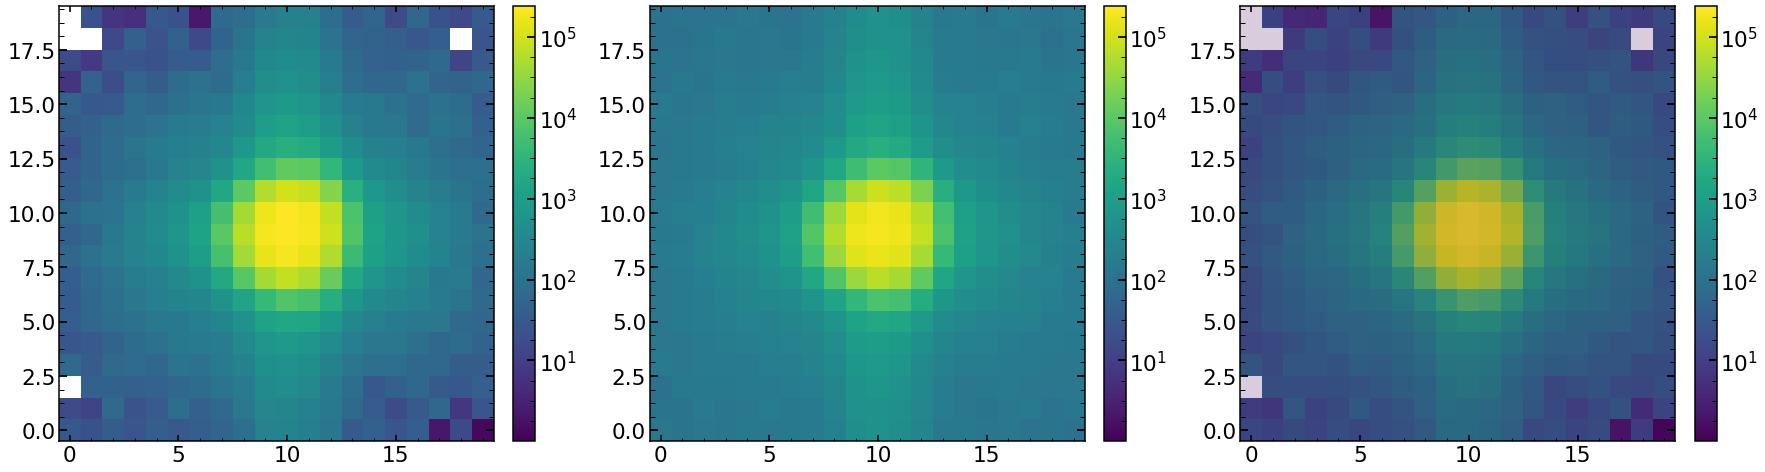

In [31]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [32]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 5380.929438215129
minimal chi2 reduced is: 19.06665524771627


In [409]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (60, 60)
Top left pixel value of the science image is: 338.15002
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 381.6772
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [   30.31229776    -0.42182597    -0.43528261     0.47914274
     0.13289489    -0.07654536    -0.35385487    -0.35668121
    -0.10561782    -0.05251076    -0.0393296     -0.01454286
    -0.0162427      0.02052808     0.0084521      0.01574609
    -0.02253111     0.03012259     0.04264008     0.67491073
     0.08982254    -0.11321028    -0.02234861     0.05591473
     0.03427195     0.00001378     0.00001378     0.97544756
     0.94834567     0.00664462    -0.05191504     0.91502452
     0.05903107     0.68305317     1.00839089  

-1138770.6292106241

In [410]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')

chi**2 reduced is: 621.7611801272317
Abs of residual divided by total flux is: 0.054733871698216446
Abs of residual divided by largest value of a flux in the image is: 0.1384532868513637


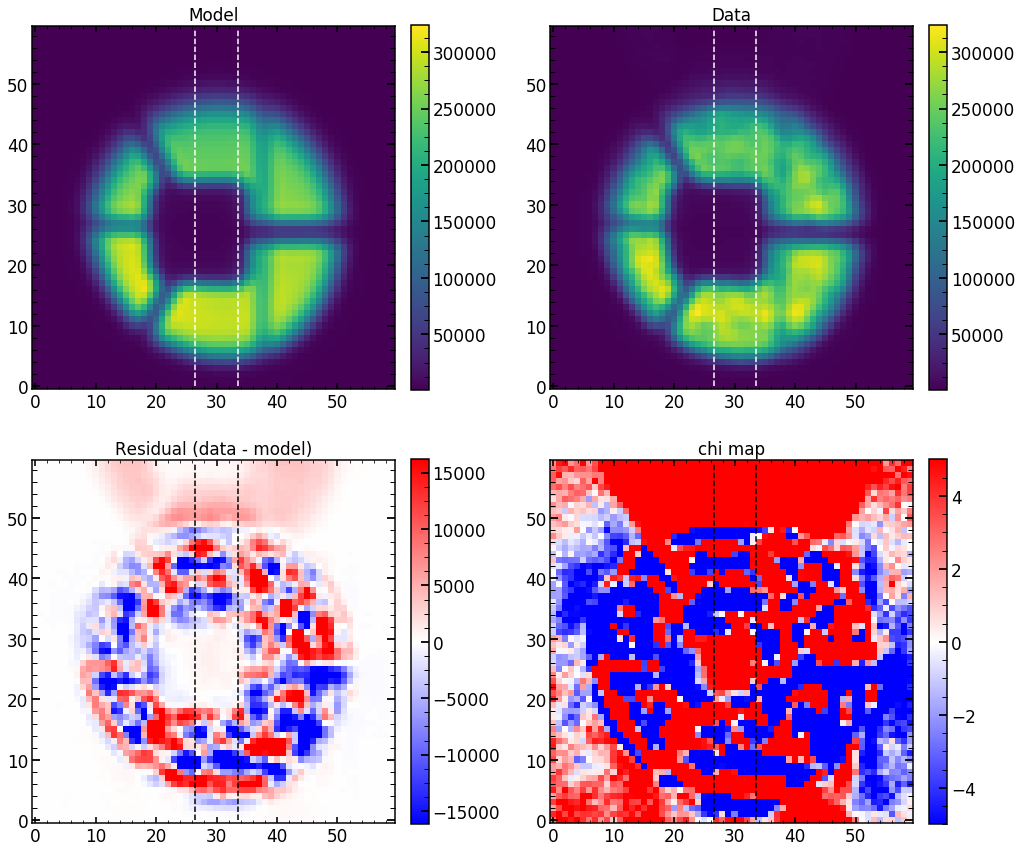

In [411]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

### ``new'' version

In [39]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (20, 20)
Top left pixel value of the science image is: 30.257544
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 135.49706
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.19806336    -0.24694844    -0.13653308     0.39085092
    -0.01095516     0.05506952    -0.50631035    -0.26016694
     0.02678486     0.11240715    -0.04227812     0.13926078
    -0.06559608     0.01425848     0.03857009     0.11374348
    -0.07798599     0.10679211     0.23054775     0.7432363
     0.08906604    -0.29028661     0.1593336      0.05469169
     0.04195337     0.0000059      0.0000059      0.97421296
     0.94834465     0.09896747    -0.03767091     0.89762369
     0.0115111      0.74360877     1.04190588  

-5330.566668651544

In [40]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')

chi**2 reduced is: 18.814841178459943
Abs of residual divided by total flux is: 0.03605289630490884
Abs of residual divided by largest value of a flux in the image is: 0.07312789163912978


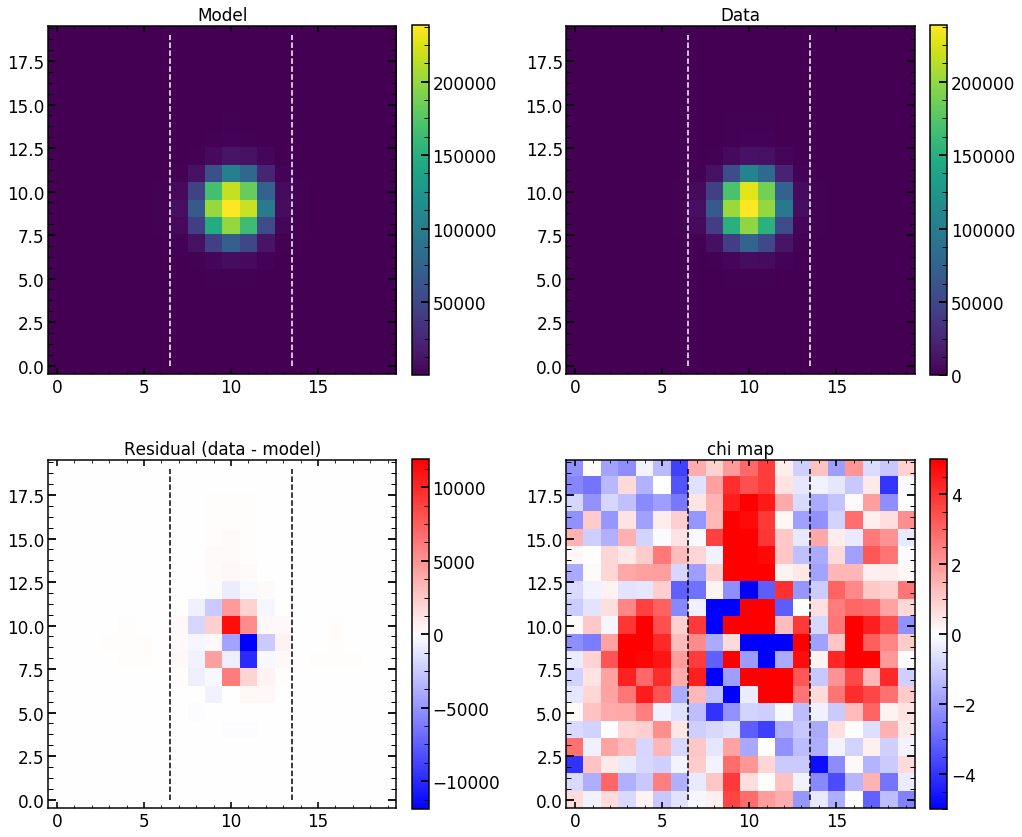

In [41]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

# Mar06

## First test few scripts 

In [43]:
def remove(string): 
    return string.replace(" ", "")

remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))

'[0,0]'

In [46]:
#MPI

list_of_HgAr_to_analyze=[51,53,54,55,56]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48,21346+60,21346+18,21346+90,21346+36,21346+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger01'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T01S'+str(single_spot)+'Mar20.sh \n')

file.close()
##################
##################
##################


list_of_Ne_to_analyze=[26,29]

for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0        

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+6,21550+102,21550+54,21550+12,21550+96,21550+48,21550+60,21550+18,21550+90,21550+36,21550+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger02'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T02S'+str(single_spot)+'Mar20.sh \n')

file.close()
##################
##################
##################

list_of_Kr_to_analyze=[27,28]

for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0  
    
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+96,21754+48,21754+60,21754+18,21754+90,21754+36,21754+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger03'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T03S'+str(single_spot)+'Mar20.sh \n')

file.close()

## which images are avaliable - Mar06

In [61]:
date='Mar0620'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [62]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][94:len(Emcee3_Ne[i])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][94:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][94:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [71]:
if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_HgAr_images)>0:
    arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
    arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]
else:
    arranged_by_defocus_HgAr=[]
    arranged_by_spot_number_HgAr=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]

In [81]:
analyzed_Kr_images

array([], dtype=float64)

In [82]:
arranged_by_spot_number_Ne

array([[21556,    26]])

In [ ]:
arranged_by_spot_number_HgAr

## single image analysis 

In [75]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [76]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [99]:

date='Mar0620'
obs=21556
obs_int=int(obs)
single_number='26'
image_index=int(single_number)
eps=5
arc='Ne'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]
double_sources=0
double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
double_sources_positions_ratios

m4


array([38.57, 0.012], dtype=object)

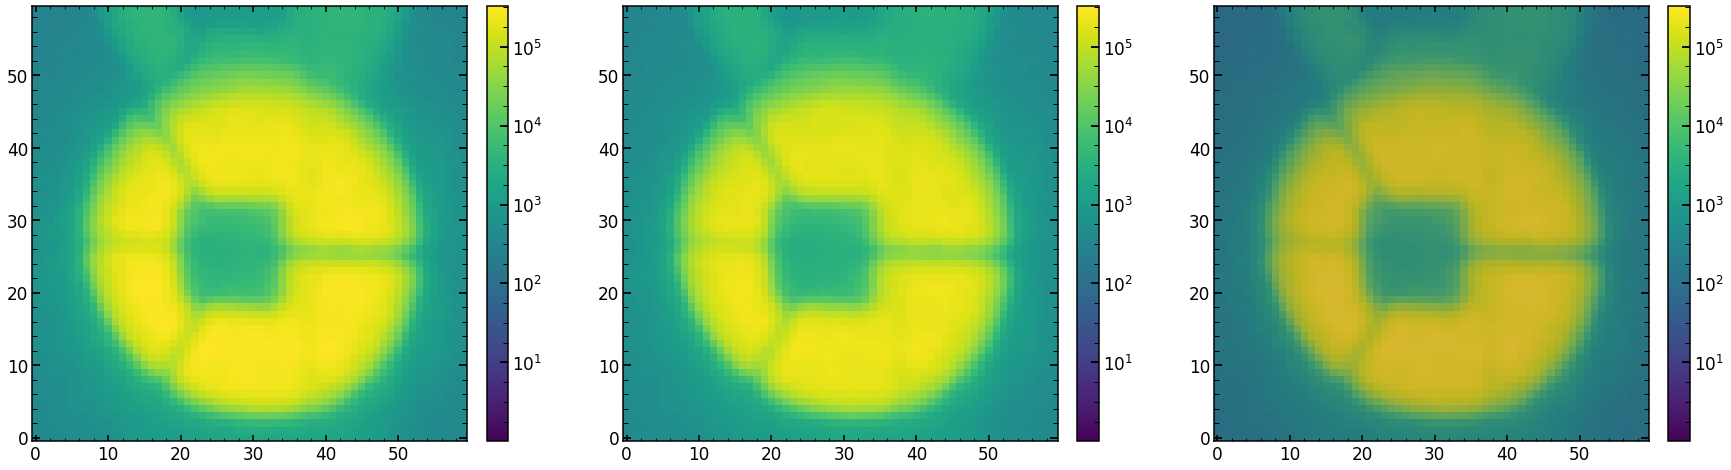

In [100]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [101]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 705615.1877680873
minimal chi2 reduced is: 381.1192688121318


In [102]:
print(minchain.shape)

if len(minchain)==42:
    columns=columns22
    
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

(42,)
          z4        z5        z6        z7        z8        z9       z10  \
0  30.312298 -0.421826 -0.435283  0.479143  0.132895 -0.076545 -0.353855   

        z11  
0 -0.356681  
        z12       z13      z14       z15       z16       z17       z18  \
0 -0.105618 -0.052511 -0.03933 -0.014543 -0.016243  0.020528  0.008452   

        z19       z20       z21  
0  0.015746 -0.022531  0.030123  
       z22   hscFrac  strutFrac  dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.04264  0.674911   0.089823 -0.11321 -0.022349  0.055915     0.034272   

   radiometricEffect  radiometricExponent    x_ilum  ...  frd_sigma  \
0           0.000014             0.000014  0.975448  ...   0.059031   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.683053  1.008391            0.400088   94608.232495   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r     flux  
0          2.360025              0.003663      0.372606  1.824542  0.99658  

[1

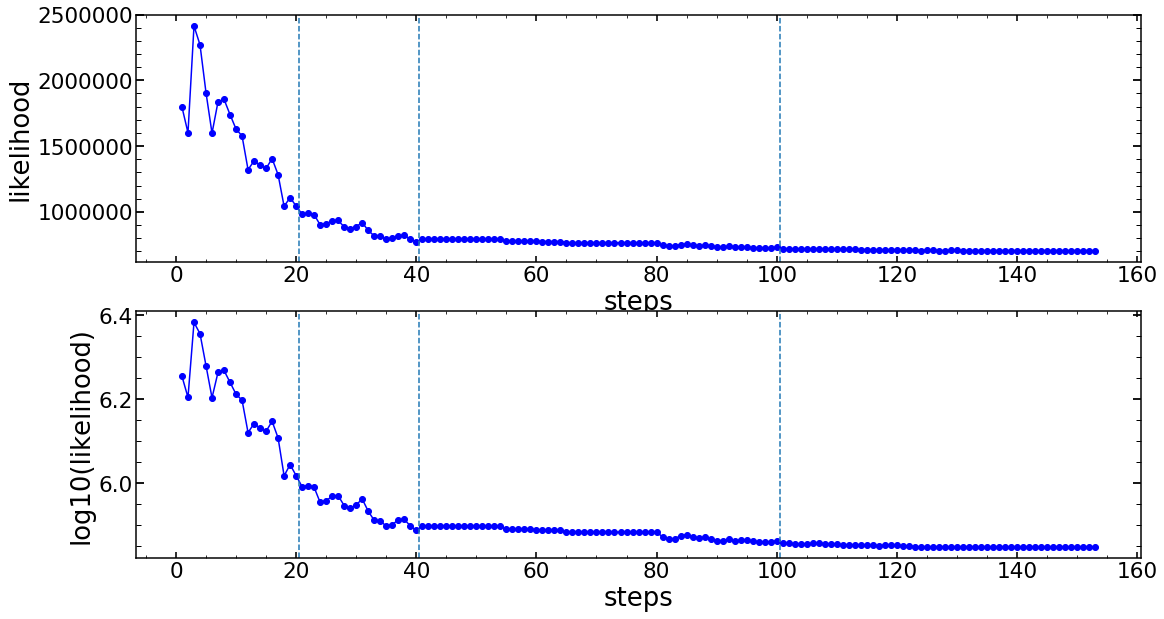

In [103]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [407]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=1,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (60, 60)
Top left pixel value of the science image is: 338.15002
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 381.6772
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [   30.31229776    -0.42182597    -0.43528261     0.47914274
     0.13289489    -0.07654536    -0.35385487    -0.35668121
    -0.10561782    -0.05251076    -0.0393296     -0.01454286
    -0.0162427      0.02052808     0.0084521      0.01574609
    -0.02253111     0.03012259     0.04264008     0.67491073
     0.08982254    -0.11321028    -0.02234861     0.05591473
     0.03427195     0.00001378     0.00001378     0.97544756
     0.94834567     0.00664462    -0.05191504     0.91502452
     0.05903107     0.68305317     1.00839089  

NameError: name 'v0' is not defined

In [105]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')


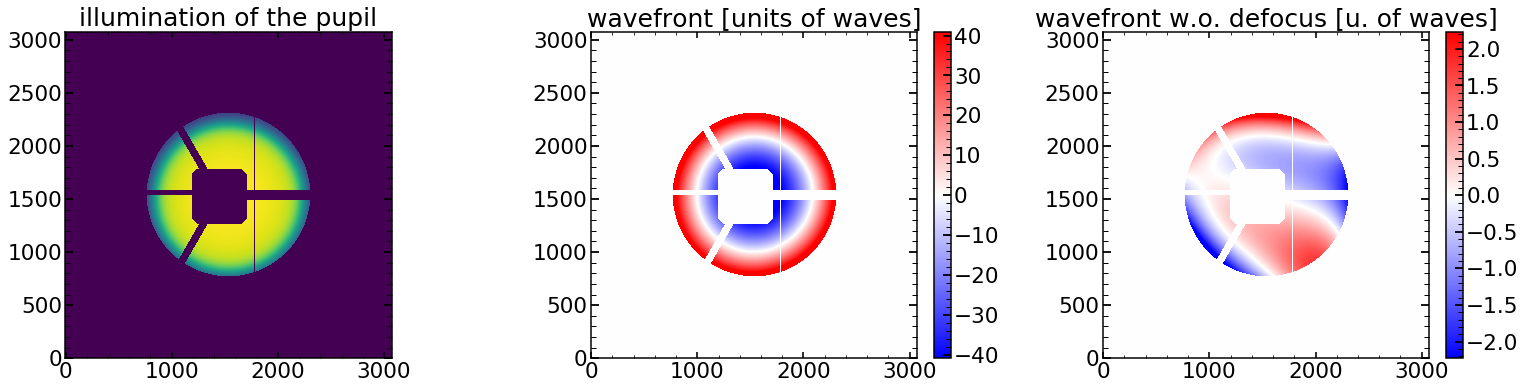

In [106]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 381.15286749058544
Abs of residual divided by total flux is: 0.05067661261356696
Abs of residual divided by largest value of a flux in the image is: 0.13456253503554164


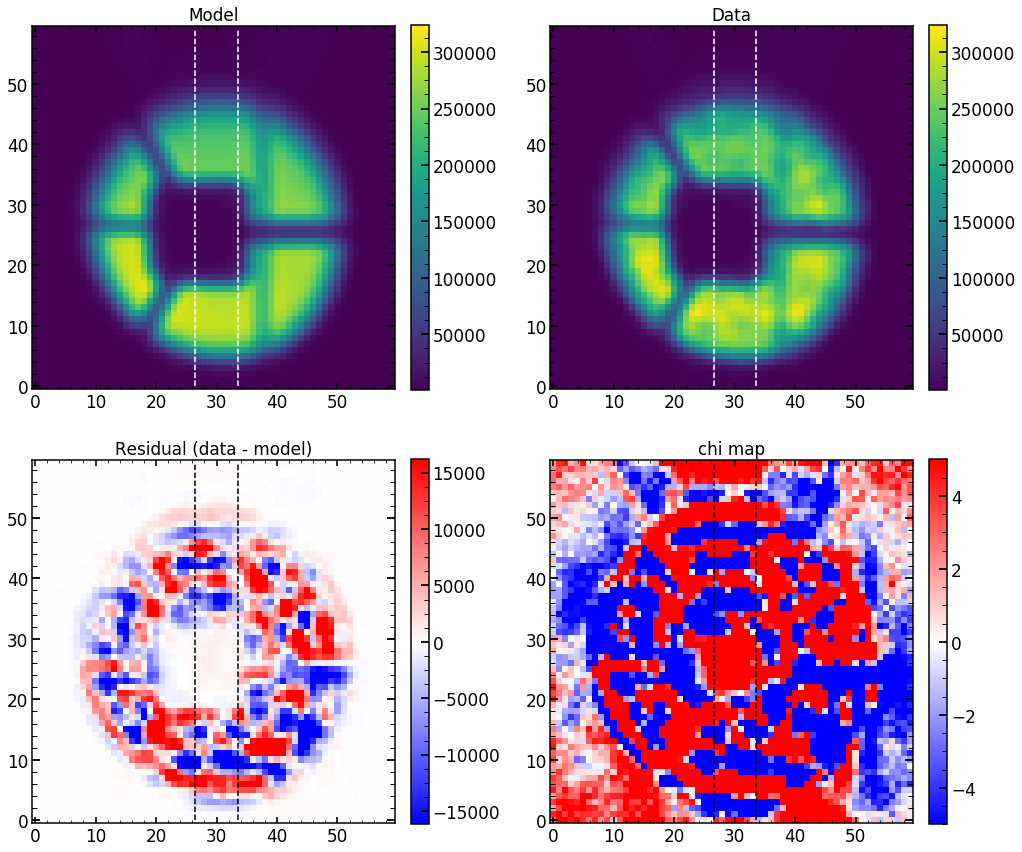

In [107]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

381.15286749058544
chi**2 reduced is: 381.15286749058544
Abs of residual divided by total flux is: 0.05067661261356696
Abs of residual divided by largest value of a flux in the image is: 0.13456253503554164


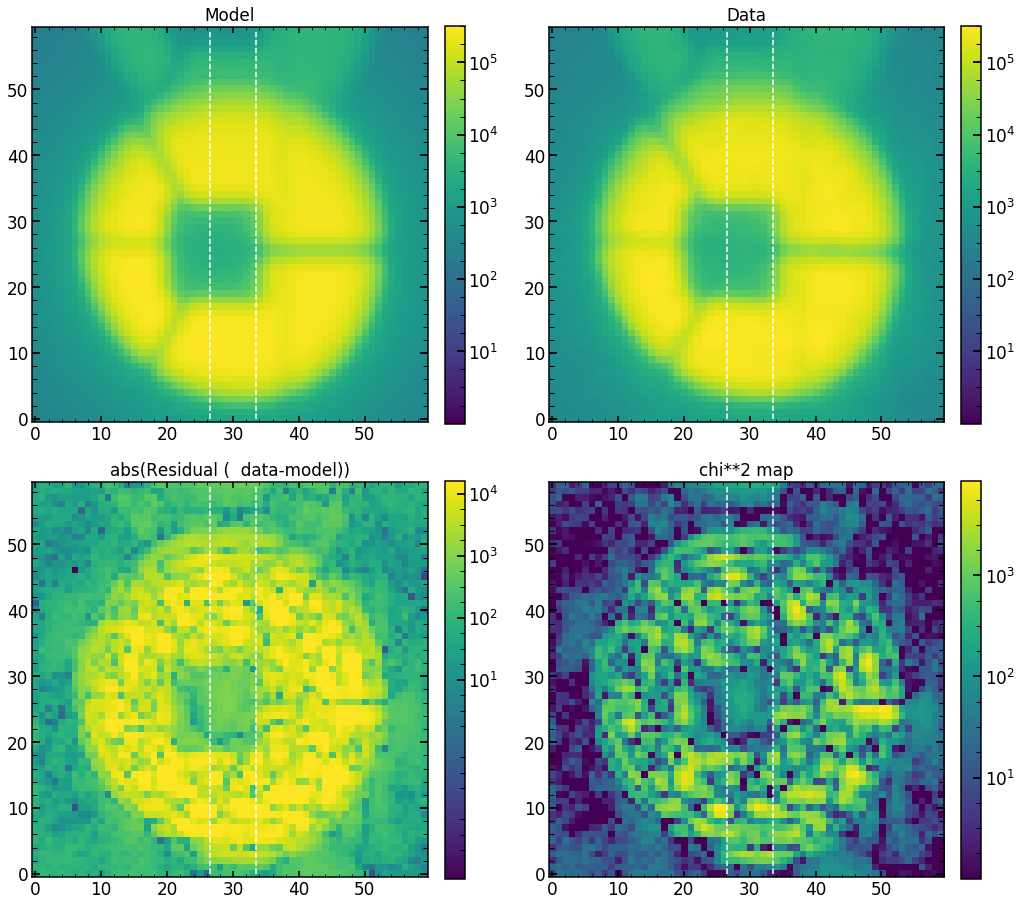

In [108]:
single_analysis.create_basic_comparison_plot_log()

381.15286749058544
chi**2 reduced is: 381.15286749058544
Abs of residual divided by total flux is: 0.05067661261356696
Abs of residual divided by largest value of a flux in the image is: 0.13456253503554164


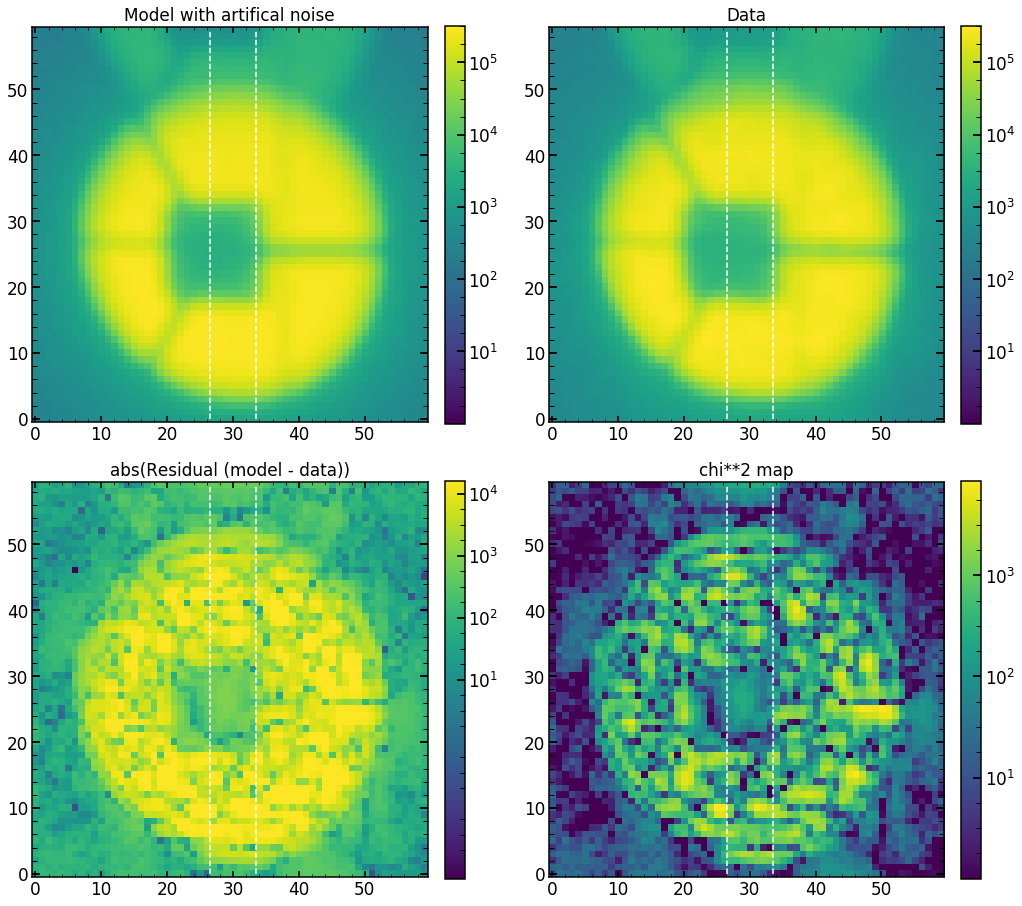

In [109]:
single_analysis.create_basic_comparison_plot_log_artifical()

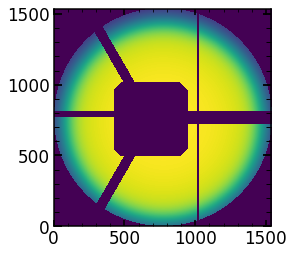

In [110]:
plt.imshow(pupililluminated)

In [122]:
import time

In [373]:
pupilScale=9.08416015625e-05
npix=1536
r=0.047086058255960184
angle=np.pi/2

In [374]:
u = (np.arange(npix, dtype=np.float32) - (npix - 1)/2) * pupilScale
u, v = np.meshgrid(u, u)

In [336]:
1536/2-0.5

767.5

In [402]:
i_max=npix/2-0.5
i_min=-i_max




pupil_illuminated_only1=np.ones((npix,npix))
pupil_illuminated_only1_test=np.ones((npix,npix))

time_start_single_square=time.time()


det_vert=1


x21 = -r/2*det_vert*1
x22 = +r/2*det_vert*1
y21 = -r/2*1
y22 = +r/2*1


# smaller than
i_y_max=int(np.round((x22+p0[1])/pupilScale - (i_min)))
i_y_min=int(np.round((x21+p0[1])/pupilScale - (i_min)))
i_x_max=int(np.round((y22+p0[0])/pupilScale - (i_min)))
i_x_min=int(np.round((y21+p0[0])/pupilScale - (i_min)))

assert angle==np.pi/2
angleRad = angle
print('angleRad'+str(angleRad))

p0=(-0.007863515945977718, -0.0015523203995101206)

time_start_single_square=time.time()

#pupil_illuminated_only1[np.logical_and(((v-p0[1])*np.sin(-angleRad)<x22) & \
#                  ((v-p0[1])*np.sin(-angleRad)>x21),\
#                  (-(u-p0[0])*np.sin(-angleRad)<y22) & \
#                  (-(u-p0[0])*np.sin(-angleRad)>y21))] = False   


pupil_illuminated_only0_in_only1=np.zeros((i_y_max-i_y_min,i_x_max-i_x_min))

print(pupil_illuminated_only0_in_only1.shape)

f=0.2
###########################################################
# Lower right corner

x21 = -r/2
x22 = +r/2
y21 = -r/2*det_vert
y22 = +r/2*det_vert


angleRad21=-np.pi/4 
triangle21=[[p0[0]+x22,p0[1]+y21],[p0[0]+x22,p0[1]+y21-y21*f],[p0[0]+x22-x22*f,p0[1]+y21]]

p21=triangle21[0]
y22=(triangle21[1][1]-triangle21[0][1])/np.sqrt(2)
y21=0
x21=(triangle21[2][0]-triangle21[0][0])/np.sqrt(2)
x22=-(triangle21[2][0]-triangle21[0][0])/np.sqrt(2)
"""
pupil_illuminated_only1[np.logical_and(((u-p21[0])*np.cos(-angleRad21)+(v-p21[1])*np.sin(-angleRad21)<x22) & \
          ((u-p21[0])*np.cos(-angleRad21)+(v-p21[1])*np.sin(-angleRad21)>x21),\
          ((v-p21[1])*np.cos(-angleRad21)-(u-p21[0])*np.sin(-angleRad21)<y22) & \
          ((v-p21[1])*np.cos(-angleRad21)-(u-p21[0])*np.sin(-angleRad21)>y21))  ] = True
    
"""
pupil_illuminated_only0_in_only1[((v0-p21[1])*np.cos(-angleRad21)-(u0-p21[0])*np.sin(-angleRad21)<y22)  ] = True

###########################################################
# Upper left corner

x21 = -r/2*1
x22 = +r/2*1
y21 = -r/2*det_vert
y22 = +r/2*det_vert
angleRad12=-np.pi/4   
triangle12=[[p0[0]+x21,p0[1]+y22],[p0[0]+x21,p0[1]+y22-y22*f],[p0[0]+x21-x21*f,p0[1]+y22]]

p21=triangle12[0]
y22=0
y21=(triangle12[1][1]-triangle12[0][1])/np.sqrt(2)
x21=-(triangle12[2][0]-triangle12[0][0])/np.sqrt(2)
x22=+(triangle12[2][0]-triangle12[0][0])/np.sqrt(2)

pupil_illuminated_only0_in_only1[ ((v0-p21[1])*np.cos(-angleRad21)-(u0-p21[0])*np.sin(-angleRad21)>y21)] = True

###########################################################
# Upper right corner
x21 = -r/2*1
x22 = +r/2*1
y21 = -r/2*det_vert
y22 = +r/2*det_vert
angleRad12=np.pi/4   
triangle22=[[p0[0]+x22,p0[1]+y22],[p0[0]+x22,p0[1]+y22-y22*f],[p0[0]+x22-x22*f,p0[1]+y22]]

p21=triangle22[0]
y22=-0
y21=+(triangle22[1][1]-triangle22[0][1])/np.sqrt(2)
x21=+(triangle22[2][0]-triangle22[0][0])/np.sqrt(2)
x22=-(triangle22[2][0]-triangle22[0][0])/np.sqrt(2)

pupil_illuminated_only0_in_only1[((u0-p21[0])*np.cos(-angleRad21)+(v0-p21[1])*np.sin(-angleRad21)>x21) ] = True  

###########################################################
# Lower right corner
x21 = -r/2*1
x22 = +r/2*1
y21 = -r/2*det_vert
y22 = +r/2*det_vert
angleRad12=np.pi/4   
triangle11=[[p0[0]+x21,p0[1]+y21],[p0[0]+x21,p0[1]+y21-y21*f],[p0[0]+x21-x21*f,p0[1]+y21]]

p21=triangle11[0]
y22=-(triangle22[1][1]-triangle22[0][1])/np.sqrt(2)
y21=0
x21=+(triangle22[2][0]-triangle22[0][0])/np.sqrt(2)
x22=-(triangle22[2][0]-triangle22[0][0])/np.sqrt(2)

pupil_illuminated_only0_in_only1[((u0-p21[0])*np.cos(-angleRad21)+(v0-p21[1])*np.sin(-angleRad21)<x22) ] = True  
### 
# end
pupil_illuminated_only1_test[i_y_min:i_y_max,i_x_min:i_x_max]=pupil_illuminated_only0_in_only1
time_end_single_square=time.time()

print('Time for cutting out the square is '+str(time_end_single_square-time_start_single_square))  


angleRad1.5707963267948966
(519, 518)
Time for cutting out the square is 0.0050008296966552734


In [403]:
pupil_illuminated_only1_test

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [369]:
i_y_max

787

In [370]:
i_y_min

714

In [357]:
u0=u[i_y_min:i_y_max,i_x_min:i_x_max]
v0=v[i_y_min:i_y_max,i_x_min:i_x_max]

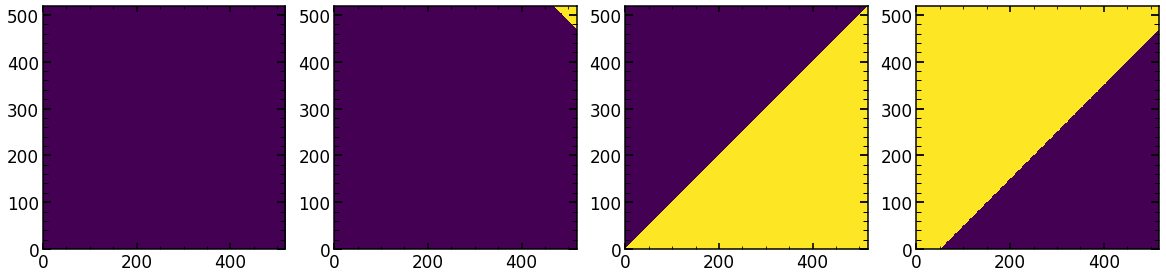

In [397]:
plt.figure(figsize=(20,10))

plt.subplot(141)
plt.imshow(((u0-p21[0])*np.cos(-angleRad21)+(v0-p21[1])*np.sin(-angleRad21)<x22))

plt.subplot(142)
plt.imshow( ((u0-p21[0])*np.cos(-angleRad21)+(v0-p21[1])*np.sin(-angleRad21)>x21))

plt.subplot(143)
plt.imshow( ((v0-p21[1])*np.cos(-angleRad21)-(u0-p21[0])*np.sin(-angleRad21)<y22))

plt.subplot(144)
plt.imshow(  ((v0-p21[1])*np.cos(-angleRad21)-(u0-p21[0])*np.sin(-angleRad21)>y21))

In [264]:
(np.arange(npix, dtype=np.float32) - (npix - 1)/2)

array([-767.5, -766.5, -765.5, ...,  765.5,  766.5,  767.5], dtype=float32)

In [345]:
int((y21+p0[0])/pupilScale - (i_min))

421

In [262]:
( (np.arange(npix, dtype=np.float32) - (npix - 1)/2) * pupilScale).shape

(1536,)

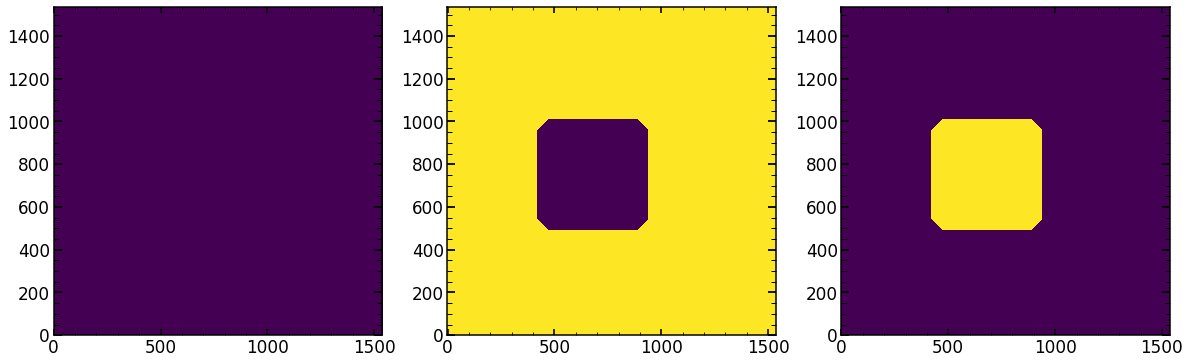

In [404]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(pupil_illuminated_only1)

plt.subplot(132)
plt.imshow(pupil_illuminated_only1_test)

plt.subplot(133)
plt.imshow(pupil_illuminated_only1-pupil_illuminated_only1_test)


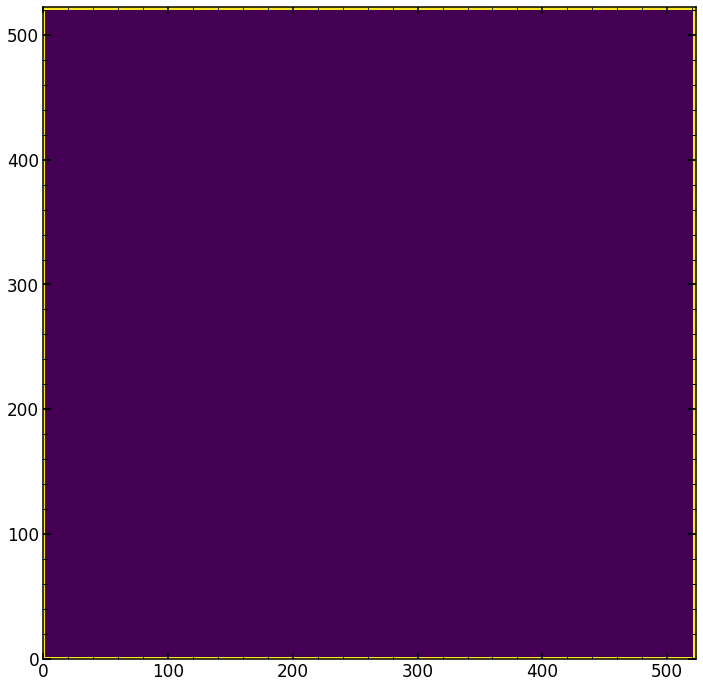

In [315]:
plt.figure(figsize=(12,12))
plt.imshow(pupil_illuminated_only1[490:1013,420:944])

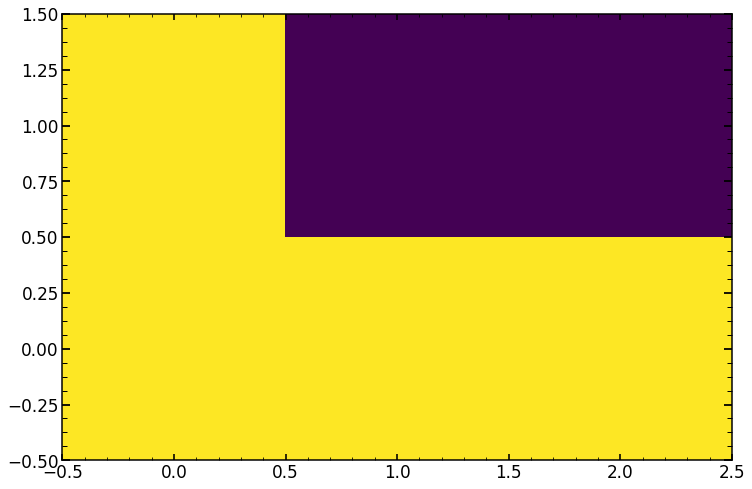

In [335]:
plt.figure(figsize=(12,12))
plt.imshow(pupil_illuminated_only1[491:493,421:424])

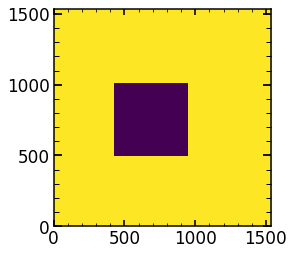

In [219]:
plt.figure(figsize=(12,12))
plt.imshow(pupil_illuminated_only1[1008:1011,820:824])

In [171]:

time_start_single_square=time.time()

np.logical_and(((u-p21[0])*np.cos(-angleRad21)+(v-p21[1])*np.sin(-angleRad21)<x22) & \
          ((u-p21[0])*np.cos(-angleRad21)+(v-p21[1])*np.sin(-angleRad21)>x21),\
          ((v-p21[1])*np.cos(-angleRad21)-(u-p21[0])*np.sin(-angleRad21)<y22) & \
          ((v-p21[1])*np.cos(-angleRad21)-(u-p21[0])*np.sin(-angleRad21)>y21)) 

time_end_single_square=time.time()
print('Time for cutting out the square is '+str(time_end_single_square-time_start_single_square))  

Time for cutting out the square is 0.004585981369018555


In [172]:
time_start_single_square=time.time()
((u-p21[0])*0.7071067811865475+(v-p21[1])*0.7071067811865475<x22) 
time_end_single_square=time.time()
print('Time for cutting out the square is '+str(time_end_single_square-time_start_single_square))  

Time for cutting out the square is 0.0016362667083740234


In [157]:
((v-p21[1])*0.7071067811865475<x22) 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [160]:
time_start_single_square=time.time()
((u-p21[0])*0.7071067811865475)
time_end_single_square=time.time()
print('Time for cutting out the square is '+str(time_end_single_square-time_start_single_square))  

Time for cutting out the square is 0.006709098815917969


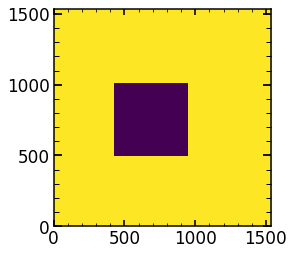

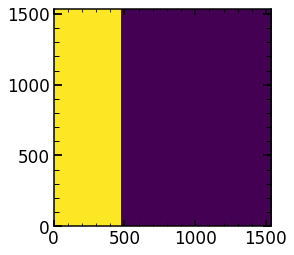

In [166]:
plt.imshow(((u-p21[0])*np.cos(-angleRad12)<x22))